In [ ]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import joblib  # For saving scaler
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pathss
processed_folder = "/content/drive/MyDrive/Colab Notebooks/766/processed_2Wavelenghts"  # Folder containing CSV files
subject_info_path = "/content/drive/MyDrive/Colab Notebooks/766/subject_info.csv"  # Subject info file
model_save_path = "/content/drive/MyDrive/Colab Notebooks/766/hemoglobin_lstm_model.h5"  # Path to save the trained model
scaler_save_path = "/content/drive/MyDrive/Colab Notebooks/766/scaler_lstm.pkl"  # Path to save the scaler
predictions_save_path = "/content/drive/MyDrive/Colab Notebooks/766/predictions_lstm.csv"  # Path to save predictions

In [ ]:
# Load subject data
subjects_df = pd.read_csv(subject_info_path)

# Convert Gender to numeric (Male=1, Female=0)
label_encoder = LabelEncoder()
subjects_df["Gender"] = label_encoder.fit_transform(subjects_df["Gender"])

# Initialize dataset list
all_data = []

# Regular expression to extract ID from filename
id_pattern = re.compile(r"(\d+)")  # Looks for numbers in the filename

# Process each CSV file
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)

        # Extract ID from filename
        match = id_pattern.search(file)
        if match:
            file_id = int(match.group(1))  # Convert ID to integer
            print(f"Processing file: {file} (ID: {file_id})")  # Debugging line

            # Read the processed CSV file
            df = pd.read_csv(file_path)

            # Find the corresponding subject data
            subject_row = subjects_df[subjects_df["id"] == file_id]

            if not subject_row.empty:
                # Merge subject data with CSV data
                subject_repeated = pd.concat([subject_row] * len(df), ignore_index=True)
                merged_df = pd.concat([df.reset_index(drop=True), subject_repeated.reset_index(drop=True)], axis=1)
                all_data.append(merged_df)
            else:
                print(f"Skipping {file}: No matching ID in subject info")

# Ensure data exists before concatenation
if not all_data:
    raise ValueError("No valid CSV files found.")

# Combine all data
data = pd.concat(all_data, ignore_index=True)


Processing file: processed_10_PPGdata.csv (ID: 10)
Processing file: processed_26_PPGdata.csv (ID: 26)
Processing file: processed_45_PPGdata.csv (ID: 45)
Processing file: processed_50_PPGdata.csv (ID: 50)
Processing file: processed_5_PPGdata.csv (ID: 5)
Processing file: processed_7_PPGdata.csv (ID: 7)
Processing file: processed_44_PPGdata.csv (ID: 44)
Processing file: processed_35_PPGdata.csv (ID: 35)
Processing file: processed_14_PPGdata.csv (ID: 14)
Processing file: processed_18_PPGdata.csv (ID: 18)
Processing file: processed_42_PPGdata.csv (ID: 42)
Processing file: processed_49_PPGdata.csv (ID: 49)
Processing file: processed_33_PPGdata.csv (ID: 33)
Processing file: processed_4_PPGdata.csv (ID: 4)
Processing file: processed_17_PPGdata.csv (ID: 17)
Processing file: processed_11_PPGdata.csv (ID: 11)
Processing file: processed_27_PPGdata.csv (ID: 27)
Processing file: processed_41_PPGdata.csv (ID: 41)
Processing file: processed_43_PPGdata.csv (ID: 43)
Processing file: processed_31_PPGdata

In [ ]:
# Split at the SUBJECT level (Not at the row level)
unique_ids = data["id"].unique()  # Get all unique subject IDs
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Filter data based on subject IDs
train_data = data[data["id"].isin(train_ids)]
test_data = data[data["id"].isin(test_ids)]

# Define features and target
X_train = train_data.drop(columns=["id", "Hemoglobin(g/L)"])  # Drop ID and target
y_train = train_data["Hemoglobin(g/L)"]

X_test = test_data.drop(columns=["id", "Hemoglobin(g/L)"])
y_test = test_data["Hemoglobin(g/L)"]

# Normalize numerical features (fit only on training set)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform using trained scaler

# Save the scaler for future predictions
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to {scaler_save_path}")

# Reshape X for CNN: (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Build the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(1)
])


# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=50, batch_size=15,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate the model
loss, mae = model.evaluate(X_test_reshaped, y_test)
y_pred = model.predict(X_test_reshaped)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Save predictions to a CSV file
predictions_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred.flatten()})
predictions_df.to_csv(predictions_save_path, index=False)
print(f"Predictions saved to {predictions_save_path}")

Scaler saved to /content/drive/MyDrive/Colab Notebooks/766/scaler_lstm.pkl
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69000/69000 ━━━━━━━━━━━━━━━━━━━━ 352s 5ms/step - loss: 1852.9508 - mae: 22.7278 - val_loss: 51.8824 - val_mae: 5.6145
Epoch 2/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 348s 5ms/step - loss: 0.1152 - mae: 0.1749 - val_loss: 49.8000 - val_mae: 5.3527
Epoch 3/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 348s 5ms/step - loss: 0.0425 - mae: 0.0956 - val_loss: 39.8783 - val_mae: 4.8230
Epoch 4/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 350s 5ms/step - loss: 0.0233 - mae: 0.0691 - val_loss: 44.4422 - val_mae: 5.2228
Epoch 5/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 352s 5ms/step - loss: 0.0168 - mae: 0.0544 - val_loss: 44.5525 - val_mae: 5.3055
Epoch 6/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 353s 5ms/step - loss: 0.0115 - mae: 0.0462 - val_loss: 71.1013 - val_mae: 6.1004
Epoch 7/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 352s 5ms/step - loss: 0.0070 - mae: 0.0375 - val_loss: 80.7713 - val_mae: 6.6664
Epoch 8/50
69000/69000 ━━━━━━━━━━━━━━━━━━━━ 351s 5ms/step - loss: 0.0048 - mae: 0.0323 - val_loss: 49.7974 - val_mae: 5.1612
Epoch 9

Model saved to /content/drive/MyDrive/Colab Notebooks/766/hemoglobin_lstm_model.h5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 17.4316 - mae: 3.4036
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Test MAE: 5.0643
Test R²: 0.7980
Predictions saved to /content/drive/MyDrive/Colab Notebooks/766/predictions_lstm.csv


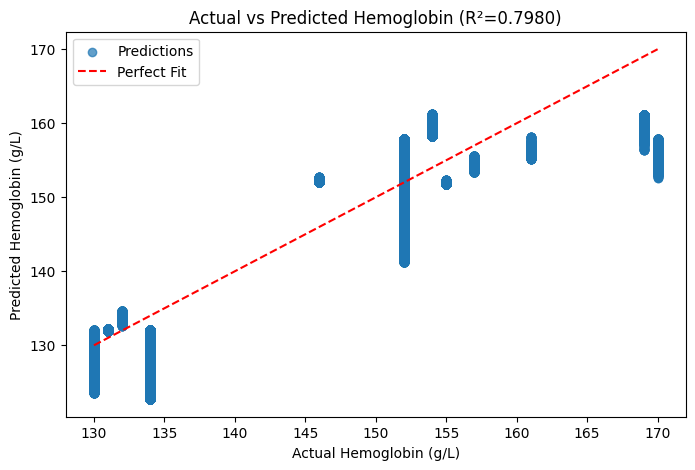

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:

# Plot Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="red", label="Perfect Fit")
plt.xlabel("Actual Hemoglobin (g/L)")
plt.ylabel("Predicted Hemoglobin (g/L)")
plt.title(f"Actual vs Predicted Hemoglobin (R²={r2:.4f})")
plt.legend()
plt.show()




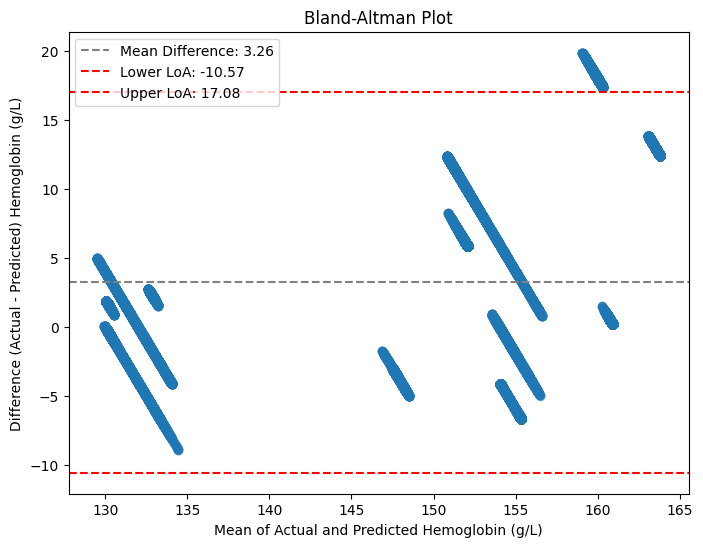

In [39]:

# Bland-Altman plot
import matplotlib.pyplot as plt

# Calculate the difference and mean
differences = y_test.values - y_pred.flatten()
mean_values = (y_test.values + y_pred.flatten()) / 2

# Calculate the mean difference, standard deviation of differences
mean_diff = np.mean(differences)
sd_diff = np.std(differences)

# Calculate limits of agreement (LoA)
lower_loa = mean_diff - 1.96 * sd_diff
upper_loa = mean_diff + 1.96 * sd_diff

# Plot Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, differences, alpha=0.5)
plt.axhline(mean_diff, color='gray', linestyle='dashed', label=f"Mean Difference: {mean_diff:.2f}")
plt.axhline(lower_loa, color='red', linestyle='dashed', label=f"Lower LoA: {lower_loa:.2f}")
plt.axhline(upper_loa, color='red', linestyle='dashed', label=f"Upper LoA: {upper_loa:.2f}")
plt.xlabel("Mean of Actual and Predicted Hemoglobin (g/L)")
plt.ylabel("Difference (Actual - Predicted) Hemoglobin (g/L)")
plt.title("Bland-Altman Plot")
plt.legend()
plt.show()
